In [1]:
#import các thư viện
import pandas as pd
import numpy as np
%matplotlib inline 
#to plot the whatever graphic
import matplotlib.pyplot as plt #plot data
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [2]:
#import data STB
df_STB = pd.read_csv('../STB-Historical-Data.csv')
df_STB = df_STB[['Date','Price']]
df_STB

,Date,Price
0,1/2/2019,"11,600.00"
1,1/3/2019,"11,100.00"
2,1/4/2019,"11,150.00"
3,1/7/2019,"11,500.00"
4,1/8/2019,"11,350.00"
...,...,...
1096,5/26/2023,"27,200.00"
1097,5/29/2023,"27,700.00"
1098,5/30/2023,"27,700.00"
1099,5/31/2023,"27,700.00"


In [3]:
#import data VNI
df_VNI=pd.read_csv('../VN Index Historical Data.csv')
df_VNI= df_VNI[['Date','Price']]
df_VNI

,Date,Price
0,1/2/2019,891.75
1,1/3/2019,878.22
2,1/4/2019,880.9
3,1/7/2019,889.64
4,1/8/2019,887.44
...,...,...
1096,5/26/2023,"1,063.76"
1097,5/29/2023,"1,074.98"
1098,5/30/2023,"1,078.05"
1099,5/31/2023,"1,075.17"


In [4]:
#Chuyển dữ liệu lần cuối, % thay đổi về dạng int
df_STB['Price']=df_STB['Price'].replace(',','',regex=True).astype(float)
df_VNI['Price']=df_VNI['Price'].replace(',','',regex=True).astype(float)

In [5]:
df = pd.merge(df_STB, df_VNI, on='Date')
df.head()

,Date,Price_x,Price_y
0,1/2/2019,11600.0,891.75
1,1/3/2019,11100.0,878.22
2,1/4/2019,11150.0,880.90
3,1/7/2019,11500.0,889.64
4,1/8/2019,11350.0,887.44


In [6]:
name_mapping = {'Price_x':'Price_STB','Price_y':'Price_VNI'}

In [7]:
df = df.rename(columns=name_mapping)
df

,Date,Price_STB,Price_VNI
0,1/2/2019,11600.0,891.75
1,1/3/2019,11100.0,878.22
2,1/4/2019,11150.0,880.90
3,1/7/2019,11500.0,889.64
4,1/8/2019,11350.0,887.44
...,...,...,...
1096,5/26/2023,27200.0,1063.76
1097,5/29/2023,27700.0,1074.98
1098,5/30/2023,27700.0,1078.05
1099,5/31/2023,27700.0,1075.17


In [8]:
# data = data.reset_index(drop=True) # Reset the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Price_STB', 'Price_VNI']]
df = df.dropna() # Drop missing values

# Split the df into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
print(len(train_data))
print(len(test_data))
print(len(val_data))

770
220
111


In [9]:
train_exog = train_data[["Price_VNI"]]
model = auto_arima(train_data['Price_STB'], 
                      test='adf',       # use adftest to find      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True,
                      exogenous= train_exog)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11656.467, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11651.101, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11651.370, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11651.352, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11652.421, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11653.355, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.553 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  770
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5823.550
Date:                Sat, 03 Jun 2023   AIC                          11651.101
Time:                        00:09:03   BIC                          11660.391
Sample:                             0   HQIC                         11654.676
    

In [10]:
model= SARIMAX(train_data['Price_STB'], 
 exog=train_exog,
 order=(2,1,2),
 enforce_invertibility=False, enforce_stationarity=False)

c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price_STB'])
test_exog = test_data[['Price_VNI']]
model_fit = model.fit()
# y_pred = model.predict(n_periods=len(y_test))
y_pred = model_fit.forecast(steps=len(y_test), exog=test_exog)
print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price_STB'])
val_exog = val_data[['Price_VNI']]
print(val_exog)
y_pred_val =  model_fit.forecast(steps=len(y_val), exog=val_exog)
print(y_pred_val)

c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


770    35562.938789
771    35983.555892
772    36057.083069
773    36157.291674
774    36189.499183
           ...     
985    25703.670279
986    25248.731934
987    25603.187443
988    25671.866078
989    25784.563571
Name: predicted_mean, Length: 220, dtype: float64
            Price_VNI
Date                 
2022-12-16    1052.48
2022-12-19    1038.40
2022-12-20    1023.13
2022-12-21    1018.88
2022-12-22    1022.61
...               ...
2023-05-26    1063.76
2023-05-29    1074.98
2023-05-30    1078.05
2023-05-31    1075.17
2023-06-01    1078.39

[111 rows x 1 columns]
770    25734.058072
771    25399.210182
772    25044.072050
773    24945.158704
774    25030.834145
           ...     
876    25979.076217
877    26237.658194
878    26308.411017
879    26242.037034
880    26316.246835
Name: predicted_mean, Length: 111, dtype: float64


c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Validation RMSE: 1143.24
Testing RMSE: 6438.76
Validation MAPE: 3.56%
Testing MAPE: 28.05%
Validation MAE: 879.30
Testing MAE: 6027.20


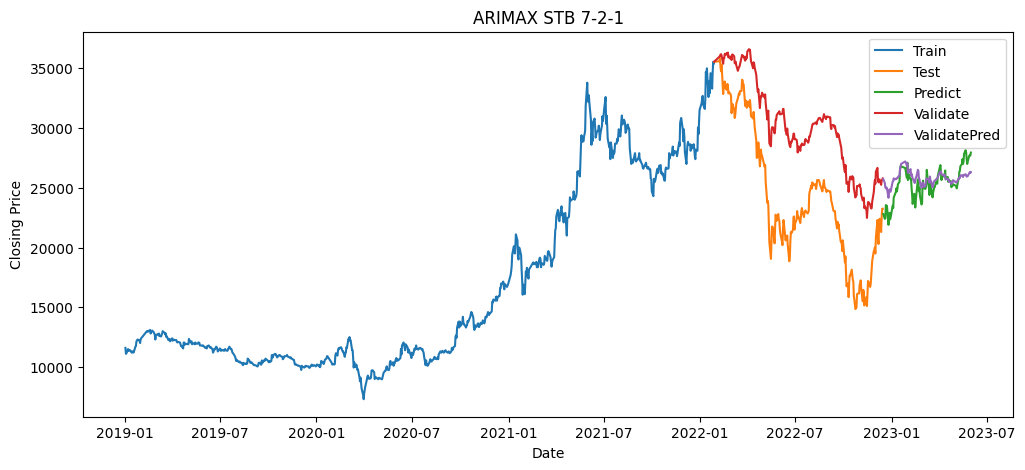

In [12]:
# 8. Tính độ đo
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
valid_mae = mean_absolute_error(y_pred_val,y_val) # MAE
test_mae = mean_absolute_error(y_pred,y_test)
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Validation MAPE: {valid_mape* 100:.2f}%")
print(f"Testing MAPE: {test_mape*100:.2f}%")
print(f"Validation MAE: {valid_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Closing Price');
plt.xlabel('Date');
plt.title('ARIMAX STB 7-2-1')
plt.plot(train_data.index, train_data['Price_STB'])
plt.plot(test_data.index, test_data['Price_STB'])
plt.plot(val_data.index, val_data['Price_STB'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
#plt.plot(next_30_days_index,y_next_30_days)
#plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.legend(['Train', 'Test', 'Predict','Validate','ValidatePred'])
plt.show()